# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [4]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]




data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

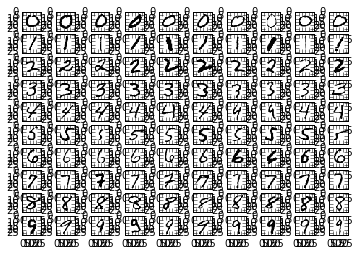

In [42]:
###P1 displays digits 0-9 on a 10 x num_examples table. You can also choose your datasets
def P1(num_examples, data, labels):
    for i in range(0,10):
        Display(i, num_examples, data, labels)


### Display shows one row of num_examples of a single digit 
def Display(n, num_examples, data, labels):
    plots = 0
    for i in range(len(data)):
        if (labels[i] == n):
            if plots < num_examples:     
                plots += 1
                p = plt.subplot(10, num_examples, plots+n*num_examples)
                m = data[i].reshape(28,28) 
                p.imshow(m, cmap='Greys',  interpolation='nearest')


    

### To answer the question let's plot a 10x10 grid showing digt examples from the train dataset
P1(10, train_data, train_labels)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [231]:
### P2 shows the accuracy of a given values of k nearest neighbors. 
### For a 1-NN results it also prints out the classification report.
def P2(k_values):


    for i in range(len(k_values)):
        KNN = KNeighborsClassifier(n_neighbors=k_values[i], weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None)
        KNN.fit(mini_train_data, mini_train_labels)
        y_pred = KNN.predict(dev_data)

        correct,total = 0,0
        for j in range(len(y_pred)):
            total +=1
            if y_pred[j] == dev_labels[j]:correct += 1
        print 'k: %1d total: %3d  correct: %3d  accuracy: %3.2f' %(k_values[i], total, correct, 1.0*correct/total)
        
        if k_values[i] == 1:
            print (classification_report(dev_labels, y_pred ))
    


k_values = [1, 3, 5, 7, 9]
P2(k_values)


k: 1 total: 1000  correct: 888  accuracy: 0.89
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

k: 3 total: 1000  correct: 878  accuracy: 0.88
k: 5 total: 1000  correct: 869  accuracy: 0.87
k: 7 total: 1000  correct: 865  accuracy: 0.86
k: 9 total: 1000  correct: 863  accuracy: 0.86


ANSWER: The most difficult digit to predict is number 9 since it has the lowest f1 score. 

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [23]:

### P3 takes different tarining sizes to measure how size affects accuracy. 
### It also prints out the time it takes to execute each 1-NN classification.
def P3(train_sizes, accuracies):


    for i in range (len(train_sizes)):
        KNN = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None)
        size = train_sizes[i]
        train_data_s, train_labels_s = X[:size], Y[:size]
        KNN.fit(train_data_s, train_labels_s)
        y_pred = KNN.predict(dev_data)

        correct,total = 0,0
        for j in range(len(y_pred)):
            total +=1
            if y_pred[j] == dev_labels[j]:correct += 1
        accuracy =1.0*correct/total
        accuracies.append(accuracy)
        print 'For a size of %3d, the time to execute prediction was %3d' %(size,time.time())


train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

For a size of 100, the time to execute prediction was 1443846811
For a size of 200, the time to execute prediction was 1443846812
For a size of 400, the time to execute prediction was 1443846812
For a size of 800, the time to execute prediction was 1443846813
For a size of 1600, the time to execute prediction was 1443846815
For a size of 3200, the time to execute prediction was 1443846819
For a size of 6400, the time to execute prediction was 1443846827
For a size of 12800, the time to execute prediction was 1443846845
For a size of 25000, the time to execute prediction was 1443846881


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [38]:
### P4 prints out a prediction of accuracy for a training size of 60000 using a regression model.
def P4():
    
    
    X = np.transpose(np.array([train_sizes]))
    Y = np.ravel(np.array([accuracies]))

    lm = LinearRegression()
    lm.fit(X, Y)
    predn = lm.predict(60000)
    print predn



P4()



[ 1.24307226]


ANSWER:  In this case the regression does not work because accuracy cannot be bigger than 1. This function shows some diminsihing returns where after certain size adding additional data does not increase accuracy. A reasonable transformation is to use the log of y as a dependent variable.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


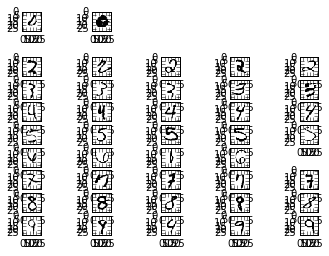

In [49]:

### P5 shows the confusion matrix and plots some examples of misclassified digits.
def P5():


    KNN = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None)
    KNN.fit(mini_train_data, mini_train_labels)
    y_pred = KNN.predict(dev_data)
    y_true = dev_labels
    print (confusion_matrix(y_true, y_pred))

    mistake_data = []
    mistake_pred = []
    mistake_labels = []
    for i in range(len(y_true)):    
        if y_pred[i] != dev_labels[i]:
            mismatch = dev_data[i]
            mistake_data.append(mismatch)
            mistake_pred.append(y_pred[i])
            mistake_labels.append(dev_labels[i])
    P1(5,mistake_data,mistake_labels)



  
    
    


P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

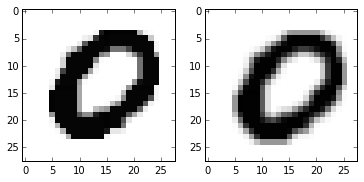

In [230]:


### P6 uses a simple average of the 8 nearest pixels to blur digits. 
### It also plots two examples to show the difference between actual vs blurred digits
def P6(data):
    

### blur_results returns a data set that is now blurred
    def blur_results(data):
        data_blur = np.zeros((len(data),784))
        blur = np.zeros((28,28))
        for index in range(len(data)):
            m = data[index].reshape(28,28) 
            p = plt.subplot(1, 2, 1)
            p.imshow(m, cmap='Greys',  interpolation='nearest')
            for i in range(28):
                for j in range(28):
                    sum_near = 0
                    for a in range(i-1,i+1):
                        if a < 0: a = 0
                        elif a >27: a = 27
                        else: a = a
                        for b in range (j-1, j+1):
                            if b < 0: b=0
                            elif b > 27: b=27
                            else: b=b

                            sum_near += m[a,b]
                    blur[i,j] = sum_near/9

            
            p = plt.subplot(1, 2, 2)
            p.imshow(blur, cmap='Greys',  interpolation='nearest')
            data_blur[index] = np.ravel(np.array([blur]))
        return data_blur
    
    return blur_results(dev_data)
         
    
train_data_blur = P6(train_data)
dev_data_blur = P6(dev_data)






ANSWER: above see examples of a actual data (left) vs blur data (right)

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [109]:

### P7 returns the accuracy of a Bernoulli NB and Multinomial NB
def P7():



    
    def Bern_results(data,labels):
        bern_data = np.zeros((len(data),784))
        for i in range(len(data)):
            for j in range(0,784):
                if data[i,j] > 0.5: bern_data[i,j] = 1
                else: bern_data[i,j]=0        
                    
        bern = BernoulliNB()
        bern.fit(data, labels)

        print 'Bernoulli accuracy: %3.2f' %bern.score(data, labels)
    
    def Multi_results(data,labels):
        multi_data = np.zeros((len(data),784))
        for i in range(len(data)):
            for j in range(0,784):
                if data[i,j] > 2/3: multi_data[i,j] = 2
                elif data[i,j] <= 1/3: multi_data[i,j] = 0
                else: multi_data[i,j]=1        
                    
        multi = MultinomialNB()
        multi.fit(data, labels)

        print 'Multinomial accuracy: %3.2f' %multi.score(data, labels)
    Bern_results(dev_data, dev_labels)
    Multi_results(dev_data, dev_labels)        



P7()

Bernoulli accuracy: 0.85
Multinomial accuracy: 0.83


ANSWER: Multinomial does not increase accuracy because it decreases the variance of each pixel making it more difficult to predict due to overfitting of the training data.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [135]:

### P8 returns the accuracies for each alpha chosen
def P8(alphas):



    clf = GridSearchCV(BernoulliNB(), alphas, cv=10)
    clf.fit(dev_data, dev_labels)
    print clf.grid_scores_
    return clf
    
    



alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

[mean: 0.09900, std: 0.00326, params: {'alpha': 0.0}, mean: 0.82800, std: 0.03947, params: {'alpha': 0.0001}, mean: 0.83100, std: 0.03910, params: {'alpha': 0.001}, mean: 0.82700, std: 0.04119, params: {'alpha': 0.01}, mean: 0.82400, std: 0.03961, params: {'alpha': 0.1}, mean: 0.81800, std: 0.03821, params: {'alpha': 0.5}, mean: 0.81500, std: 0.04103, params: {'alpha': 1.0}, mean: 0.80800, std: 0.04119, params: {'alpha': 2.0}, mean: 0.78200, std: 0.05705, params: {'alpha': 10.0}]


In [138]:
### Best alpha when using Laplace smoothing and its corresponding accuracy
print nb.best_params_
print nb.best_score_


{'alpha': 0.001}
0.831


ANSWER: The best results we get is 0.831 for an alpha of 0.001. Notice that when alpha is zero we get accuracy of only 0.0990. This is not what we expect since for alpha zero we should have got the same results of 0.85 that we got in the question before. 

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [229]:
### P9 runs Gaussian NB models for a dataset modified by a factor that makes its value bigger.
def P9(factor, data, labels):


    gau = GaussianNB()
    gau.fit((data)**(factor), labels)

    print 'gaussian accuracy: %3.2f' %gau.score((data)**(factor), labels)
    return gau


gnb = P9(1,dev_data,dev_labels)
print gnb.theta_
print gnb.sigma_

gnb = P9(10,dev_data,dev_labels)
print gnb.theta_
print gnb.sigma_

new_dev_data = (np.array([ j + np.random.normal(1) / 30 for j in dev_data]))

gnb = P9(1,new_dev_data,dev_labels)



gaussian accuracy: 0.72
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 ..., 
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]]
gaussian accuracy: 0.75
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0

ANSWER:  We can see that by adding more variability to the data we get a better model with an accuracy of 0.81. Initially it does not work as well because the way digits are drawn affect the pixels on the canvas differently. It's too difficult to get consistent behavior of all pixels for the same digit. We also see that just by increasing the pixels value by a factor improves its accuracy up to a point.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

[[ 0.00990099  0.00990099  0.00990099 ...,  0.00990099  0.00990099
   0.00990099]
 [ 0.00934579  0.00934579  0.00934579 ...,  0.00934579  0.00934579
   0.00934579]
 [ 0.00961538  0.00961538  0.00961538 ...,  0.00961538  0.00961538
   0.00961538]
 ..., 
 [ 0.00869565  0.00869565  0.00869565 ...,  0.00869565  0.00869565
   0.00869565]
 [ 0.01020408  0.01020408  0.01020408 ...,  0.01020408  0.01020408
   0.01020408]
 [ 0.00925926  0.00925926  0.00925926 ...,  0.00925926  0.00925926
   0.00925926]]
Bernoulli accuracy: 0.85


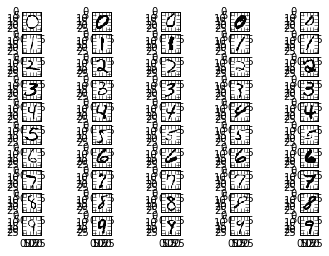

In [241]:
def P10(num_examples, data, labels):

### STUDENT START ###
    
    
    def Bern_results(data,labels):
        bern_data = np.zeros((len(data),784))
        for i in range(len(data)):
            for j in range(0,784):
                if data[i,j] > 0.5: bern_data[i,j] = 1
                else: bern_data[i,j]=0        
                    
        bern = BernoulliNB()
        bern.fit(data, labels)
        print np.exp(bern.feature_log_prob_)
        print 'Bernoulli accuracy: %3.2f' %bern.score(data, labels)
    Bern_results(data,labels) 
    P1(num_examples, data, labels)

P10(5, dev_data, dev_labels)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [17]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

#buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
#correct = [0 for i in buckets]
#total = [0 for i in buckets]

#P11(buckets, correct, total)

#for i in range(len(buckets)):
#    accuracy = 0.0
#    if (total[i] > 0): accuracy = correct[i] / total[i]
#    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()